# Imports & parameters

In [3]:
#--------------------------------------------------------
#Import section
#--------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


#--------------------------------------------------------
#Parameters
#--------------------------------------------------------

#Parameters for pandemic simulation

Population = 1000
inf_chance = 2
Death_Prob = 1
Grid_Size = 10

#Parameters for network generation

Mean_Size = 10
Influencers = []
Influencer_Size = Mean_Size * 5
op_thresh = .05

#Vaccination / Opinion Parameters

Stubb_coeff = .5
Vacc_threshold = 0.34
Dose_Per_Day = 5
pro = 200
neutral = 750
contra = 50

#Timespan for simulation/ Amount of runs to average

Duration = 1000
runs = 5

#--------------------------------------------------------
#Helper functions
#--------------------------------------------------------

def Variance(lists):
    
    index = len(lists)
    variances = []
    
    for i in range(0,Duration):
        to_comp = []
        for j in range(0,index):
            to_comp.append(lists[j][i])
        variances.append(np.var(to_comp))
    return variances
        

def GetRandList(low, high, size):
    
    """
    Returns a list of randomly generated numbers without doubles
    Parameters:
        low:            Lower bound
        high:           upper bound
        size:           lengt of the desired list
    """
    
    Rand = []
    while (len(Rand) < size):
        r = np.random.randint(low, high)
        if r not in Rand: Rand.append(r)
    return Rand
    
def Gen_Op_List(pro,neutral,anti):
  
    """
    Generates a list with the desired amount of pro/neutral/contra 
    opinions withing the specific thresholds. 
    Parameters:
        pro:            Amount of pro opinions
        neutral:        Amount of neutral opinions
        anti:           Amount of contra opinions
    """
    
    list_op = []
    for i in range(0,anti):list_op.append(np.random.uniform(-1,-.33))
    for i in range(0,neutral):list_op.append(np.random.uniform(-.32,.33))  
    for i in range(0,pro):list_op.append(np.random.uniform(.34, 1))
    np.random.shuffle(list_op)
    return list_op

def MeanLength(Dict):
    
    """
    Returns the mean amount of values for a key inside a dict
    Parameters:
        Dict:           Dict to be analyzed
    """
    
    mean_sum = 0  
    for key in Dict.keys(): mean_sum += len(Dict[key])
    return mean_sum/len(Dict.keys())
        
def GenNet(Mean_Size, Nodes_Special_Treatment = [], special_mean_size = 0):
    
    """
    Generation of a scale-free network according to a mean size defined, 
    option to generated larger networks for incluencer nodes
    Parameters:
        Mean_Size:                  Mean size of network for each person
        Nodes_Special_Treatment:    list of indices of Nodes which will be influencers
        special_mean_size:          Desired size of influencer networks
    """
    
    Lower = (Mean_Size * 2)//2 - 1
    Upper = ((Mean_Size)*2)//2 + 3
    Dict_ = {}
    for i in range(0,Population):
        
        Connections = np.random.randint(Lower,Upper)
        Nodes = GetRandList(0, Population, Connections)
        Dict_[i] = Nodes
 
    low_con = (special_mean_size*2)//2 - 1
    high_con = (special_mean_size*2)//2 + 3
        
    for node in Nodes_Special_Treatment:
        con_special = np.random.randint(low_con,high_con)
        Inc_Pop = GetRandList(0, Population, con_special)
        Dict_.update({node : Inc_Pop})
           
    return Dict_

## Person class

In [4]:
#--------------------------------------------------------
#Person Class definition
#--------------------------------------------------------

class Person():
    """
    A class used to represent a Person in our Town

    Attributes
    ----------
    status : int
        health status of a person (deafault 0). 
    opinion : float
        Initial opinion of Person    
    immunity : int
        number of days until immunity wears off
    recovery_time : int
        number of days to recover from covid-19
    Network : list of Person Objects
        List of other persons in the network     
    ID : int
        Identifier of a Person
    Persuasion : float
        How convinced a person is of their opinion
    Household : int
        Assigns person objects to an integer, people with the same household
        assignment value are grouped together into the same household
    RoomMates : List of person objects
        Lists other people with the same household value
    stubborn : int
        How set a person is on its opinion

    Methods
    -------
    CheckHealth()
        A function to treat each health condition with its appropriate reaction
    """

    def __init__(self):

        self.status = 0
        self.opinion = 0
        self.immunity = 60
        self.recovery_time = 10
        self.Network = []
        self.ID = -1
        self.persuasion = 0
        self.HouseHold = -1
        self.RoomMates = []
        self.stubborn = -1

    def CheckHealth(self):

        chance_Death = np.random.randint(0,1000)
        
        if self.status == 1 and chance_Death < Death_Prob: 
            self.status = 3
        elif self.status == 1 and self.recovery_time > 0:
            self.recovery_time -= 1
        elif self.status == 1 and self.recovery_time == 0:
            self.status = 2
            self.recovery_time = 10

        elif self.status == 2 and self.immunity > 0: self.immunity -= 1
        elif self.status == 2 and self.immunity <= 0:
            self.status = 0
            self.immunity = 60
 
#--------------------------------------------------------
#Town Class definition
#--------------------------------------------------------         

## Town class

In [5]:
class Town():
    """
    A class used to represent a Town filled with Person objects according to 
    Population

    Attributes
    ----------
    grid        : 2D array (Grid_Size x Grid_Size)
                  Serves as the area of the town, used for simulating meetings
    inhabitants : list of Person objects
                  A list containing all Person objects assigned to the Town
    location    : List of tuples (x,y), storing location of each inhabitant
                  number of days until immunity wears off
    Status      : list of int
                  List to store the status of each person, used for DataFrame creation
    DF          : pandas DataFrame 
                  List containing Person, Status and Location of each person, used for runtime improvements
    Household   : List of People grouped into their respective household
    Networks    : Dict
                  Dict of each transition of the network assigned to the respective
                  Person index as key value, with transition indices as values
    Vacc        : List of indices
                  Stores people willing to get vaccinated


    Methods
    -------
    influencer(node, Iopinion, Istubborn, Ipers)
        Allows assigning specific values for opinion, persuasion and stubborness to chosen nodes
    Mean_Network_Length()
        Calculates the mean size of the inhabitants networks
    Interact()
        Person interacts with a subset of their Network
    CheckDeath_Household()
        Removes dead people from households
    CheckDeath_Network()
        Removes dead people from networks
    Op_Mean()
        Calculates the mean opinion of the Town
    Opinions()
        Returns distribution of Opinions as a list of [Nr. of Pro, Nr. of neut, Nr. of contra]
    Infect()
        Infects 10 randomly chosen inhabitants to start the simulation
    Infected()
        Returns the number of infected people
    Immune()
        Returns the number of immune people
    Death()
        Returns the number of dead people
    Healthy()
        Returns the amount of susceptible people
    Vaccinated()
        Returns the amount of vaccinated people
    Spread()
        Scans the Grid for instances where multiple people are at the same location
        Upon finding such a bundle, if one of the people is infected, it generates a 
        random chance for infection for each other person on this location
    Move()
        After each daycycle, inhabitants are assigned a new location on the grid 
        at random, where they again can spread the virus
    Get_vacc()
        Randomly vaccinates people in the vaccination list according to doses available per day
        If more doses are available than people wanting to get vaccinated, only vaccinate the
        amount of people that want a vaccine
    """

    def __init__(self , influencers = [] , inf_pers = [], inf_stubb = []):

        init_op = Gen_Op_List(pro,neutral,contra)    
        self.Network = GenNet(Mean_Size, influencers, Influencer_Size)
        self.grid = np.zeros((Grid_Size, Grid_Size))
        self.inhabitants = []
        self.location = []
        self.Status = []
        self.HouseHolds = []
        self.Networks = []
        self.Vacc = []

        checked_HouseHold = []

        for i in range(0, Population):
            
            P = Person()
            
            self.inhabitants.append(P)
            self.inhabitants[i].ID = i
            self.location.append(
                (np.random.randint(0, Grid_Size), np.random.randint(0, Grid_Size)))
            self.Status.append(P.status)
            self.inhabitants[i].HouseHold = np.random.randint(0,Population//4)

        Dict = {'Person': self.inhabitants,
            'Location': self.location, 'Status': self.Status}
        self.DF = pd.DataFrame(data=Dict)
        
        for id_p, person in enumerate(self.inhabitants):
            
            Op = init_op.pop(0)
            person.persuasion = Op
            

            if (abs(Op) - 0.1) >= 0.7 :person.stubborn = 1
            else: person.stubborn = abs(Op) * Stubb_coeff
            
            if id_p in influencers:
                
                person.persuasion = inf_pers.pop(0)
                person.stubborn = inf_stubb.pop(0)
            
            
            if person.persuasion <= -.33: person.opinion = -1
            elif person.persuasion <= .34 and Op > -.33: person.opinion = 0
            elif person.persuasion >= .34: person.opinion = 1
        
        for key in self.Network:

            self.inhabitants[key].Network.append(self.inhabitants[key])
            for value in self.Network[key]:
              self.inhabitants[key].Network.append(self.inhabitants[value])

        # Add People to household. Each person in the household is added to network as well
        for person in self.inhabitants:    
            for other_person in self.inhabitants:
                if other_person.HouseHold == person.HouseHold and other_person.ID != person.ID:
                    person.RoomMates.append(other_person)
                    if other_person not in person.Network:
                        person.Network.append(other_person)
                        
        # Add people to clustered network
        for person in self.inhabitants:
           for other_person in self.inhabitants:
               if person.ID != other_person.ID and person.persuasion - op_thresh < other_person.persuasion and person.persuasion + op_thresh > other_person.persuasion:
                   if other_person not in person.Network: person.Network.append(other_person)
                   
        # List of Households
        for person in self.inhabitants:
           
           if person.HouseHold not in checked_HouseHold: 
               self.HouseHolds.append(person.RoomMates)
               checked_HouseHold.append(person.HouseHold)
               
       # Generate Vacc List of people willing to get vaccinated
        for person in self.inhabitants:
            if person.opinion == 1 and (person.status == 0 or person.status == 2) : self.Vacc.append(person)
            
          
    def influencer(self, node, Iopinion, Istubborn, Ipers):
        
        self.inhabitants[node].opinion = Iopinion 
        self.inhabitants[node].persuasion = Ipers 
        self.inhabitants[node].stubborn = Istubborn 
       
    def Mean_Network_Length(self):
       
       length = 0 
       for person in self.inhabitants:
           
           length += len(person.Network)
       return length/Population

    def Interact(self):

      #create a random list of people out of the persons network
      for person1 in self.inhabitants:
        
        network_Size = np.random.randint(2,len(person1.Network)//2)
        Factor = Population
        indices = GetRandList(0,len(person1.Network),network_Size)
        dayNetwork=[]
        for index in indices:
          dayNetwork.append(person1.Network[index])
          
        for person2 in dayNetwork:

          #Both people have the same opinion
          if person1.opinion == person2.opinion and person1.opinion != 0:
            delta = abs(person1.persuasion - person2.persuasion) / Factor
            if abs(person1.persuasion) > abs(person2.persuasion): 
                if person2.stubborn != 1: person2.persuasion += person1.opinion * delta
            else:
                if person2.stubborn != 1: person1.persuasion += person1.opinion * delta
          #Opposite opinion:
          if person1.opinion != person2.opinion and person1.opinion != 0 and person2.opinion != 0:  
              delta = abs(person1.persuasion - person2.persuasion) / Factor
              if person1.opinion == 1:
                  if person1.stubborn < person2.stubborn: person1.persuasion += delta
                  elif person1.stubborn > person2.stubborn: person2.persuasion -= delta
              elif person2.opinion == 1:
                  if person1.stubborn < person2.stubborn: person1.persuasion -= delta
                  elif person1.stubborn > person2.stubborn: person2.persuasion += delta

          #if person2 is set and person1 is undecided influence person1
          elif (person1.opinion == 0) and (person2.opinion != 0):
            if person2.opinion == 1: person1.persuasion = person1.persuasion + abs(person1.persuasion - person2.persuasion)/Factor
            else: person1.persuasion = person1.persuasion - abs(person1.persuasion - person2.persuasion)/Factor
          #if person1 is set and person2 is undecided influence person2
          elif (person1.opinion != 0) and (person2.opinion == 0):
            if person1.opinion == 1 : person2.persuasion  = person2.persuasion + abs(person1.persuasion - person2.persuasion)/Factor
            else: person2.persuasion  = person2.persuasion - abs(person1.persuasion - person2.persuasion)/Factor
      
        for person in self.inhabitants:
            
          if person.persuasion >= .34 and person.opinion == 0: person.opinion = 1
          elif person.persuasion <= -.33 and person.opinion == 0: person.opinion = -1
          
          if (abs(person.persuasion) - 0.1) >= 0.7 :person.stubborn = 1
          else: person.stubborn = abs(person.persuasion) * Stubb_coeff
   
    def CheckDeath_Household(self):
        
        flag_Death = False
        for house in self.HouseHolds:
            
            for id_p, person in enumerate(house):
                
                if person.status == 3:
                    house.pop(id_p)
                    flag_Death = True
            if flag_Death == True:

                flag_Death = False

    def CheckDeath_Network(self):
        
        for NW in self.Network:
            list_death = []

            for value in self.Network[NW]:
                if self.inhabitants[value].status == 3:
                    
                    list_death.append(value)

            for death in list_death:
                self.Network[NW].remove(death)
                self.inhabitants[NW].Network.remove(self.inhabitants[death])
            
             
    def Op_Mean(self):
        
        Op = 0
        for person in self.inhabitants:
            Op += person.opinion
        
        return Op/Population
    
    def Opinions(self):
        
        pro = 0
        neut = 0
        con = 0
        for person in self.inhabitants:
            
            if person.opinion == 1: pro += 1
            elif person.opinion == 0: neut += 1
            elif person.opinion == -1: con += 1
            
        return [pro,neut,con]

    def Infect(self):

        Infections = GetRandList(0, Population, 10)

        for Infection in Infections:
            self.DF.at[Infection, "Status"] = 1
            self.DF.at[Infection, "Person"].status = 1

    def Infected(self):
        tracker = 0
        for person in self.inhabitants:
            if person.status == 1: tracker += 1
        return tracker

    def Immune(self):
        tracker = 0
        for person in self.inhabitants:
            if person.status == 2: tracker += 1
        return tracker

    def Death(self):
        tracker = 0
        for person in self.inhabitants:
            if person.status == 3: tracker += 1
        return tracker
    def Healthy(self):
        tracker = 0
        for person in self.inhabitants:
            if person.status == 0: tracker += 1
        return tracker
    def Vaccinated(self):
        tracker = 0
        for person in self.inhabitants:
            if person.status == 4: tracker += 1
        return tracker

    def Spread(self):

        for i in range(0, Grid_Size):
            for j in range(0, Grid_Size):
                Occupants = self.DF[self.DF["Location"] == (i, j)]

                if Occupants.size > 3 and 1 in Occupants.values:

                    for ind in Occupants.index:
                        chance = np.random.randint(0, 100)
                        if self.DF.iloc[ind]["Person"].status == 0 and chance < inf_chance:
                            self.DF.at[ind, "Person"].status = 1
                            
        for person in self.inhabitants:
            if person.status != 1: continue
            for other_person in person.RoomMates:
                if other_person.status == 0:
                    chance = np.random.randint(0,100)
                    if chance < inf_chance: other_person.status = 1
                

    def Move(self):
       newLoc = [(np.random.randint(0, Grid_Size), np.random.randint(
           0, Grid_Size)) for i in range(Population)]
       self.DF.Location = newLoc

       for i in range(0, Population):

           self.inhabitants[i].CheckHealth()
           self.DF.at[i,"Status"] = self.inhabitants[i].status

    def Get_vacc(self):
       
       
       To_Remove = []
       for i in range(0, len(self.Vacc)):

           if self.Vacc[i].status != 0 and self.Vacc[i].status != 2:
               To_Remove.append(i)
       To_Remove.sort()
       To_Remove = To_Remove[::-1]
       for remove in To_Remove:
           self.Vacc.remove(self.Vacc[remove])
       
       for person in self.inhabitants:
           if person.opinion == 1 and (person.status == 0 or person.status == 2) and person not in self.Vacc: self.Vacc.append(person)
         
       if len(self.Vacc) < Dose_Per_Day: To_Vacc = GetRandList(0, len(self.Vacc),len(self.Vacc))

       else: To_Vacc = GetRandList(0, len(self.Vacc),Dose_Per_Day)
       
       To_Vacc.sort()
       To_Vacc = To_Vacc[::-1]
       Vacc_tracker = 0
       for ind in To_Vacc:
               person = self.Vacc[ind]
               person.status = 4

               self.DF.at[ind, "Status"] = 4
               self.Vacc.remove(person)
               Vacc_tracker += 1

# Run simulation

0
1
2
3
4


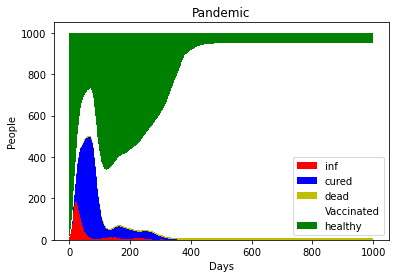

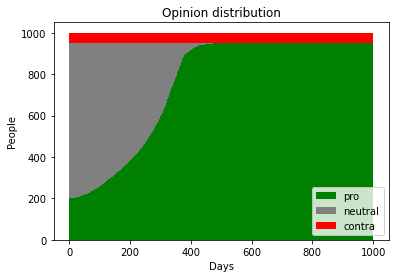

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16000000000000003, 0.64, 0.8, 0.56, 0.64, 1.04, 1.36, 2.0, 2.0, 1.36, 1.44, 1.44, 1.44, 2.0, 1.04, 1.04, 1.36, 1.44, 2.0, 1.8399999999999999, 1.36, 2.96, 3.44, 5.36, 4.639999999999999, 5.76, 8.16, 9.84, 5.4399999999999995, 5.4399999999999995, 8.959999999999999, 11.36, 10.16, 10.559999999999999, 6.16, 6.16, 5.36, 4.239999999999999, 4.96, 4.16, 2.8, 3.3600000000000003, 8.639999999999999, 9.84, 10.16, 9.44, 8.239999999999998, 8.239999999999998, 8.959999999999999, 6.239999999999999, 6.8, 7.359999999999999, 9.36, 8.4, 7.4399999999999995, 5.6, 5.4399999999999995, 6.0, 5.76, 3.7600000000000002, 5.36, 7.039999999999999, 8.559999999999999, 8.559999999999999, 12.559999999999999, 16.16, 16.8, 20.4, 19.759999999999998, 19.439999999999998, 19.359999999999996, 24.159999999999997, 20.56, 23.759999999999998, 29.439999999999998, 25.359999999999996, 24.8, 23.359999999999996, 21.839999999999996, 28.159999999999997, 34.559999999999995, 35

In [6]:
#Generation of tracking lists

all_inf_tracker = []
all_imm_tracker = []
all_death_tracker = []
all_healthy_tracker = []
all_Vacc_tracker = []
all_Op_tracker = []

all_pro = []
all_neut = []
all_con = []

Op_tracker_pro = [0 for i in range(0,Duration+1)]
Op_tracker_neut = [0 for i in range(0,Duration+1)]
Op_tracker_con = [0 for i in range(0,Duration+1)]

#Simulation for amount of runs, summing up the results and averaging them afterwards

for run in range(runs):
  print(run)
  inf_tracker = []
  imm_tracker = []
  death_tracker = []
  healthy_tracker = []
  Vacc_tracker = []
  pros = []
  neuts = []
  cons = []

  T = Town(influencers = [1,2], inf_pers = [-1,0.8], inf_stubb = [1,1])
  T.Infect()

  inf_tracker.append(T.Infected())
  imm_tracker.append(T.Immune())
  death_tracker.append(T.Death())
  healthy_tracker.append(T.Healthy())
  Vacc_tracker.append(T.Vaccinated())

  pros.append(T.Opinions()[0])
  neuts.append(T.Opinions()[1])
  cons.append(T.Opinions()[2])

  Op = T.Opinions()
  Op_tracker_pro[0] += Op[0]
  Op_tracker_neut[0] += Op[1]
  Op_tracker_con[0] += Op[2]
  
  for i in range(0, Duration):

      T.Spread()
      T.Move()
      T.Get_vacc()
      T.CheckDeath_Household()
      T.CheckDeath_Network()
      T.Interact()
      inf_tracker.append(T.Infected())
      healthy_tracker.append(T.Healthy())
      imm_tracker.append(T.Immune())
      death_tracker.append(T.Death())
      Vacc_tracker.append(T.Vaccinated())
      Op_day = T.Opinions()
      Op_tracker_pro[i+1] += Op_day[0]
      Op_tracker_neut[i+1] += Op_day[1]
      Op_tracker_con[i+1] += Op_day[2]
      
      pros.append(Op_day[0])
      neuts.append(Op_day[1])
      cons.append(Op_day[2])
      


  all_inf_tracker.append(inf_tracker)
  all_imm_tracker.append(imm_tracker)
  all_death_tracker.append(death_tracker)
  all_healthy_tracker.append(healthy_tracker)
  all_Vacc_tracker.append(Vacc_tracker)
  
  all_pro.append(pros)
  all_neut.append(neuts)
  all_con.append(cons)
  
  

all_inf_tracker =  np.array(all_inf_tracker)
all_imm_tracker = np.array(all_imm_tracker)
all_death_tracker = np.array(all_death_tracker)
all_healthy_tracker = np.array(all_healthy_tracker)
all_Vacc_tracker = np.array(all_Vacc_tracker)
all_Op_tracker = np.array(all_Op_tracker)

mean_inf_tracker =[0 for data in all_inf_tracker[0]]
mean_imm_tracker = [0 for data in all_inf_tracker[0]]
mean_death_tracker = [0 for data in all_inf_tracker[0]]
mean_healthy_tracker = [0 for data in all_inf_tracker[0]]
mean_Vacc_tracker = [0 for data in all_inf_tracker[0]]
mean_Op_tracker = [0 for data in all_inf_tracker[0]]

mean_inf_tracker = np.array(mean_inf_tracker)
mean_imm_tracker = np.array(mean_imm_tracker)
mean_death_tracker = np.array(mean_death_tracker)
mean_healthy_tracker = np.array(mean_healthy_tracker)
mean_Vacc_tracker = np.array(mean_Vacc_tracker)
mean_Op_tracker = np.array(mean_Op_tracker)


for resultSet in range(len(all_inf_tracker)):
  mean_inf_tracker = mean_inf_tracker + all_inf_tracker[resultSet]
  mean_imm_tracker = mean_imm_tracker + all_imm_tracker[resultSet]
  mean_death_tracker = mean_death_tracker + all_death_tracker[resultSet]
  mean_healthy_tracker = mean_healthy_tracker + all_healthy_tracker[resultSet]
  mean_Vacc_tracker = mean_Vacc_tracker + all_Vacc_tracker[resultSet]
  


inf = mean_inf_tracker/runs
imm = mean_imm_tracker/runs
death = mean_death_tracker/runs
healthy = mean_healthy_tracker/runs
Vacc = mean_Vacc_tracker/runs
#Op = mean_Op_tracker/runs

Op_tracker_pro = np.array(Op_tracker_pro)
Op_tracker_pro = Op_tracker_pro/runs
Op_tracker_neut = np.array(Op_tracker_neut)
Op_tracker_neut = Op_tracker_neut/runs
Op_tracker_con = np.array(Op_tracker_con)
Op_tracker_con = Op_tracker_con/runs


axs = plt.figure(1)

#Generate stacked bar chart for the pandemic

p1 = plt.bar(np.arange(0, Duration + 1), inf,width = 1, color='r')
p2 = plt.bar(np.arange(0, Duration + 1), imm, color='b',width = 1,bottom = inf)
p3 = plt.bar(np.arange(0, Duration + 1), death, color = 'y',width = 1, bottom = inf + imm)
p4 = plt.bar(np.arange(0, Duration + 1), Vacc, color = 'w' , width = 1, bottom = inf + imm + death)
p5 = plt.bar(np.arange(0, Duration + 1), healthy, color = "g" ,width = 1, bottom = inf + imm + death + Vacc)
plt.legend( (p1,p2,p3,p4,p5), ("inf", "cured" , "dead" ,"Vaccinated" ,"healthy"))
plt.title("Pandemic")
plt.xlabel("Days")
plt.ylabel("People")


axs1 = plt.figure(2)

#Generate stacked bar chart for opinions

p6 = plt.bar(np.arange(0,Duration + 1), Op_tracker_pro,width = 1, color = "g")
p7 = plt.bar(np.arange(0,Duration + 1), Op_tracker_neut,width = 1, color = "gray", bottom = Op_tracker_pro)
p8 = plt.bar(np.arange(0,Duration + 1), Op_tracker_con,width = 1, color = "r", bottom = Op_tracker_pro + Op_tracker_neut)
plt.legend( (p6,p7,p8), ("pro", "neutral", "contra"))
plt.title("Opinion distribution")
plt.xlabel("Days")
plt.ylabel("People")

plt.show()

print(Variance(all_pro))
print(Variance(all_neut))
print(Variance(all_con))

In [7]:
print(death[-1])
print(Op_tracker_pro[-1])
print(Op_tracker_neut[-1])
print(Op_tracker_con[-1])
print(Vacc[-1])

7.2
948.8
0.0
51.2
941.6
